## Detecting Gravitational Waves with GRACE-FO

In order to evaluate whether the NASA GRACE-FO climate satellite can be used as a gravitational wave detector, we attempt to place a fake signal of a black hole binary merger in simulated data and recover it via a matched filter. This document serves as an explanatory overview of this process. 

We will make use of several Python packages including matplotlib, numpy, and PyCBC which was created for GWA with the LIGO detectors. You can find more information on PyCBC [here](https://pycbc.org/)!

##### Step 1 - Getting and Displaying GRACE-FO ASD

The GRACE-FO Amplitude Spectral Density (ASD), which is the square root of the Power Spectral Density (PSD), was taken from [this paper](https://arxiv.org/pdf/2002.02044.pdf) and written into a csv file. We will read in the csv contents as a numpy array and extract the ASD and frequencies over which it's defined. We will then plot it to ensure it was done correctly. 

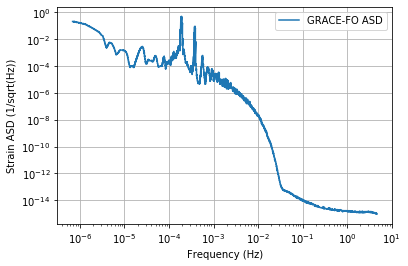

In [3]:
#Import necessary python packages
import csv
import numpy as np
import matplotlib.pyplot as plt

#Read in GRACEFO data from csv
fileobj = open('GRACE.csv', 'r')
readerobj = csv.reader(fileobj)

data = []
for row in readerobj:
    data.append(row)
    
fileobj.close()

#Extract frequency and Strain data
data_array = np.array(data, dtype='d')
grace_freqs = data_array[0:,0] #the first column contains the frequencies the ASD is defined over in HZ
grace_strain = data_array[0:,1] #the second column contains the ASD in m/sqr(HZ)
grace_asd = grace_strain / 220.0e3 # dividing by 220*10^3m converts between m/sqr(Hz) to 1/sqr(Hz) ie the proper ASD

plt.loglog(grace_freqs, grace_asd, label='GRACE-FO ASD')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain ASD (1/sqrt(Hz))')
plt.grid()
plt.show()

##### Step 2 - Modeling the GRACE-FO Data in the Time Domain

As of now we have the GRACE-FO ASD which characterizes the measured GRACE-FO signal & signal strength across its frequency bandwidth. However, in order to perform a matched filter we will need the signal's time domain equivalent as this is what GRACE-FO will actually measure. While we could take an inverse Fourier transform via numpy's ifft function to take the ASD from the frequency domain to the time domain, we will instead model the signal in the time domain to avoid complication. 

To model the noise curve we begin by generating some white noise at GRACE-FO's sampling frequency of 10 Hertz (which means each sample is a discrete 0.1 seconds apart). White noise is simply a signal of random values (in the time domain) taken from some distribution that corresponds to flat power spectrum in the frequency domain. A flat power spectrum means that the signal strength at each frequency is roughly the same.

As you can see from GRACE's ASD above, the signal strength is not the same across the frequency bandwidth. We can imitate this by taking our generated white noise and applying PyCBC's lowpass filter to it to create a frequency dependent power spectrum. The lowpass will cause the signal strength to drop off in power at all frequencies greater than a chosen pass frequency. Because GRACE-FO's ASD has a rather unique shape that was difficult to model with just one lowpass filter, we will actually generate two noise arrays and apply a different lowpass to each before later merging them.

Before we go on, I wanted to make note that I convert the time domain data to a PyCBC object called a timeseries because it has several useful attributes and methods. There will also be a corresponding frequency domain object called a frequencyseries that we will use later. [Here](https://pycbc.org/pycbc/latest/html/pycbc.types.html) is the PyCBC documentation on these objects.

In [ ]:
from pycbc import types

N = 2000000 #length of time domain data 

#generate a white noise signal
np.random.seed(138374923)
noise1 = np.random.uniform(-1, 1, size=N)
            
#convert the white noise to TimeSeries pycbc object
noise1_ts = types.timeseries.TimeSeries(noise1, delta_t=0.1) #delta_t = 0.1 to match gracefo sample frequency of 10 Hz
        
#adjust amplitude of noise before filtering it
noise1_ts = noise1_ts * 10e-8

The lowpass filter has several parameters that we can adjust to change the resulting frequencyseries's shape. The cutoff refers to the chosen frequency above which all other signal frequency strength will be attenuated. The order and beta parameter affect how quickly the attenuation drops to zero and how smooth the resulting frequencyseries will be.

In [ ]:
cutoff = 0.001 
order = 950 
beta = 17  

#filtering our white noise
filtered1 = noise1_ts.lowpass_fir(cutoff, order, beta=beta)

##### Step 2.1 - Checking the Data Model in the Frequency Domain

We now want to plot our filtered noise in the frequency domain in order to compare it to GRACE's ASD. In order to accomplish this, we will need a method of changing time domain data to its frequency domain counterpart. To do so we will use, yep you guessed it, a Fourier transform. However, we can't just run the data through an FFT because this will cause aliasing of the signal. Aliasing refers to the spectral leakage that occurs when a periodic signal is not perfectly sampled in phase (). [Here](https://jackschaedler.github.io/circles-sines-signals/dft_leakage.html) is a helpful interactive tutorial that explains aliasing in a little more depth. 

To deal with aliasing we instead convert the timeseries to a frequencyseries via Welch's Method. Welch's Method is essentially a dressed up FFT with additional steps to better counter leakage. It works by first dividing up the timeseries into a number of subsections. Then it applies a window to each subsection and takes the FFT of it. The window counters aliasing by forcing the beginning and ending of each subsection to zero. Finally each subsection's FFT is averaged together to provide a PSD estimate (). Additionally, each subsection actually overlaps each other by a specified amount to ensure that the use of windowing does not change the data. [Here](https://www.youtube.com/watch?v=YK1F0-3VvQI) is a quick video that summerizes the subject.

The first function below utilizes PyCBC's [Welch's Method](https://pycbc.org/pycbc/latest/html/pycbc.psd.html) to return the frequencyseries PSD estimate of the inputted timeseries. It is configured to automatically use a 50% overlap of each subsection. The second function utilizes the [Welch's Method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html) function of Python's Scipy package. It's here for reference as it functions similarly to the first function. However, you may be able to find more reference examples of its use than for PyCBC's method.

In [ ]:
def pyc_welch(ts, seg_size):
    
    #input the data timeseries as ts and the size of the subsection you want to use as seg_size. 
    #changing the size of the subsection affects how smooth your final estimate is.
    
    #the output is the frequencyseries PSD estimate
    
    from pycbc import psd
    
    seg_len = int(seg_size)
    seg_stride = int(seg_len / 2)
    
    fs = psd.welch(ts, seg_len=seg_len, seg_stride=seg_stride, avg_method='mean')
   
    return fs

def test_welch(ts, fs, seg_size):
    
    #the inputs are the same except for fs which is the sampling frequency of the time domain data
    #the outputs are two seperate arrays: freqs is the x values in the frequency domain
    #psd is the psd estimate (the y values in the frequency domain)
    
    #if you want to use the frequencyseries attributes on the PSD estimate, 
    # you must also convert the output to a frequency series
    
    from scipy import signal
    
    nperseg = int(seg_size)
    noverlap = nperseg // 2
    freqs, psd = signal.welch(ts, fs, nperseg=nperseg, noverlap=noverlap, 
                              scaling='density' )
    
    return freqs, psd

We now apply Welch's Method to our colored noise and plot it against GRACE's ASD. You will notice that the model doesn't fit GRACE's ASD below 0.01 Hz. We aren't planning to detect gravitational waves from merger events that peak in this portion of GRACE's bandwidth because the noise power is too great.

In [ ]:
seg_size = 150000

noise1_psd = pyc_welch(filtered1, seg_size)
noise1_asd = np.sqrt(noise1_psd)

plt.figure()
plt.loglog(noise1_asd.sample_frequencies, noise1_asd, label='noise 1')
plt.legend()
plt.xlabel('Hz')
plt.ylabel('1/sqrt(Hz)')
plt.grid()
plt.show()

##### Continuing the Data Models

Now that we checked that our first generated noise timeseries matches part of GRACE's ASD, we generate a second timeseries of white noise to apply another lowpass filter with different parameters. 

In [ ]:
cutoff = 0.00001
order = 14000
beta = 11.0

#generate a white noise signal
noise2 = np.random.uniform(-1, 1, size=N)
    
#convert the white noise to TimeSeries pycbc object
noise2_ts = types.timeseries.TimeSeries(noise2, delta_t=0.1)

#adjust amplitude
noise2_ts = noise2_ts * 10e-8

#filter it
filtered2 = noise2_ts.lowpass_fir(cutoff, order, beta=beta)

#estimate it's PSD for comparison
noise2_psd = welch_function.pyc_welch(filtered2c, seg_size)
noise2_asd = np.sqrt(noise2_psd)

#compare our modeled noise ASD to GRACE's ASD
plt.figure()
plt.loglog(noise2_asd.sample_frequencies, noise2_asd, label='noise 2')
plt.legend()
plt.xlabel('Hz')
plt.ylabel('1/sqrt(Hz)')
plt.grid()
plt.show()

##### Step 2.2 - Combine the Colored Noise Data

The next step is to combine our two colored noise timeseries for a complete model of our data.

In [ ]:
#uncomment to check dimensions of each timeseries as the filters can affect their length
#print(np.size(filtered1), np.size(filtered2))

#pad the smaller one with zeros to the length of the larger one
#padding with zeros won't introduce any new frequency power to the signal
filtered2.append_zeros((np.size(filtered1)-np.size(filtered2)))

#uncomment to check that the sizes match
#print(np.size(filtered1), np.size(filtered2))

#Sum the two colored noise models
merged_noise = np.array(filtered1) + np.array(filtered2)
merged_noise_ts = types.timeseries.TimeSeries(merged_noise, delta_t=0.1) #ensures same delta_t

#Take the PSD estimate of the noise model
noise_psd = welch_function.pyc_welch(merged_noise_ts, seg_size)

#Plot against GRACE's ASD for comparison
plt.figure()
plt.loglog(noise_psd.sample_frequencies, np.sqrt(noise_psd), label='Modeled Noise ASD')
plt.loglog(grace_freqs, grace_asd, label='GRACE-FO ASD')
plt.legend()
plt.xlabel('Hz')
plt.ylabel('1/sqrt(Hz)')
plt.grid()
plt.show()

In [ ]:
#Export the noise data as csv?

##### Step 3 - Creating a Mock Gravitational Wave Signal

Now that we have our simulated GRACE-FO timeseries data we can start playing with it! Remember that our ultimate goal is to perform a matched filter on the GRACE-FO timeseries data to find hidden gravitational waves. To do that we first have to hide a simulated gravitational wave in our data to later find. 

Our problem is to now simulate the gravitational waves emitted by two coalescing black holes! If you don't really know anything about gravitational waves, read the background statement below. Otherwise, we'll keep talking about the analysis. PyCBC has a great function for generating gravitational wave signals which I'll refer to as waveforms from here on out. The function, get_td_waveform uses previously developed models to generate the strain amplitude of the two gravitational waveform polarizations. The function, get_td_waveform, also lets us submit important parameters such as the masses of the black holes, their distance from us, and the time step size we want for the resulting waveform timeseries. I suggest playing with some of the parameters below to see how they affect the resulting waveform. Particularly important are the mass and distance parameters. A more complete list of parameters can be found [here](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html) and another example [here](https://pycbc.org/pycbc/latest/html/waveform.html).

###### Some GW Background

When a black hole captures another black hole in it's orbit, the moving masses cause the generation of ripples in surrounding spacetime. This phenomenon is analogous to electromagnetic waves (EM waves) emitted from an accelerating charged particle. Much like the EM waves, gravitational waves propogate outwards from their source system and carry energy away from it....


In [ ]:
from pycbc.waveform import get_td_waveform

# The solar masses of the black holes
m1 = 10.0
m2 = 10.0

# The lower frequency cutoff to begin generating the signal at
f_lower = 30.0

# The model of the gravitational-wave signal we are using
approximant = 'SEOBNRv4_opt'

# The time between samples that we want (this is arbitrarily set)
delta_t = 1.0 / 4096

# The Distance in million parsecs (1 parsec ~ 3.3 light years)
# This ignores redshift due to expansion of the universe (luminosity distance)
d = 10 


#Generate the waveform
h_plus, h_cross = get_td_waveform(approximant=approximant,
                         mass1=m1, mass2=m2,
                         delta_t=delta_t, f_lower=f_lower,
                         distance=d)

plt.figure()
plt.plot(h_plus.sample_times, h_plus, label='Plus polarization')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

##### Step 3.1 - Creating a Mock Signal via Analytic Approximation

Although PyCBC's get_td_waveform is excellent, there is one problem in trying to use it for our purposes. As you may have noticed, the function has a parameter called f_low. Gravitational waves from binary black hole mergers are chirp signals that change in period and increase in frequency as the merger progresses. f_low picks the lowest frequency to begin the waveform at and can help save computational time by drastically shortening the waveform since the waveform will contain many cycles of low frequencies prior to the merger and only a few to a fraction of a cycle at higher frequencies closer to the merger time.

Because the waveform models were created with LIGO in mind as their intended detector, the models don't incorporate f_lows set below about 10 Hz as this is the lower limit of LIGO's frequency bandwidth. If you refer back to the GRACE-FO ASD, our bandwidth is from ~0.01-5.0 Hz. By using get_td_waveform for creating a waveform we will actually be missing the portion of the waveform that GRACE-FO will be most sensitive to.

In order to counteract this, we developed a function, inspiral_strain that produces a waveform based upon the analytical point-mass Newtonian approximation for two black holes in a circular orbit. This approximation only generates the inspiral portion of the gravitational waveform as modeling the waveform around and after the merger requires significantly more sophisticated and complex methods (). However, we only care about lower frequencies from the inspiral phase that GRACE will be sensitive to, so this approximation is satisfactory for now.

##### Overview of 'inspiral_strain'

To help you gain an understanding of the approximation I'll walk you through the steps and equations....

In [ ]:
#Our Waveform Generator

#Chirp Mass Calculator - the equations used in inspiral_strain depend on the chirp mass of the black holes
def chirp_mass(m1, m2): #enter masses as solar mass multiples
    sol_mass = 1.989e30
    mass1 = sol_mass*m1
    mass2 = sol_mass*m2
    
    m_chirp = ( ((mass1*mass2)**(3.0/5.0)) / ( (mass1+mass2)**(1.0/5.0) ))
    return m_chirp

def inspiral_strain(m1, m2, f_lower, dt, r, theta):
    
    #input masses in solar masses and distance in parsecs
    
    #the output is three arrays: first the time vector over which the strain is defined
    #the second and third are the two strain polarizations
    
    #define some important quantities
    sol_mass = 1.989e30
    G = 6.67e-11
    c = 3.0e8
    distance = r*(3.0857e16)
    M_c = chirp_mass(m1,m2)
    m_tot = float( sol_mass * (m1 + m2) )
    m1_kg = sol_mass * m1
    m2_kg = sol_mass * m2
    
    #define some scaling factors for later equation simplification
    A = (1.0/distance) * (((G*M_c) / (c**2.0))**(5.0/4.0))
    B = (6.0 * (6.0 **(1.0/2.0)) * (5.0**(3.0/8.0)) ) / (256.0**(3.0/8.0))
    
    #1 - find cutoff time (ie time at which isco is reached and tau min is reached) from eqts 4.39 and 4.19
    num = B * (G**(3.0/8.0)) * (m_tot**(9.0/8.0)) 
    den = c**(9.0/8.0) * ( (m1_kg * m2_kg)**(3.0/8.0) )
    tau_min = ( num / den )**(8.0/3.0)
    
    #2 - find time to coalescence using equation 4.21, given a lower frequency limit
    time_until_coalescence = 2.18*((1.21*1.989e30)/M_c)**(5.0/3.0) * (100.0/float(f_lower))**(8.0/3.0)
    
    #3 - find tau now as a function of observer time instead of retarded time (pg 170)
    obs_t = np.arange(0, int(time_until_coalescence - tau_min), dt)
    tau = int(time_until_coalescence) - obs_t #don't subtract cutoff_time here to ensure tau does not go to zero)
    
    #4 - find Phi from equation 4.30
    Phi = -2.0 * ( ( (5.0*G*M_c)/(c**3.0) )**(-5.0/8.0) ) * (tau**(5.0/8.0) )
    
    #5 - calculate plus and cross polarizations from equations 4.31 and 4.32
    h_plus = A*((5.0/(c*tau))**(1.0/4.0)) * (1+(np.cos(theta)**2.0)) * 0.5 * np.cos(Phi)
    h_cross = A*((5.0/(c*tau))**(1.0/4.0)) * (np.cos(theta)) * np.sin(Phi)
        
    return obs_t, h_plus, h_cross

##### Step 3.2 - Generate and Process the Gravitational Waveform

Now we create an arbitrary waveform with parameters that will allow GRACE-FO to detect the result (ie a somewhat close distance within the radius of the Milky Way and a pair on intermediate mass black holes). We initially generate the waveform at a higher sampling frequency that GRACE's to avoid discontinuities in the waveform, so we downsample it before truncating the beginning and end of the waveform in order to have it taper to zero at both ends.

In [ ]:
import zero_finder

#Generate inspiral model waveform from q_c_orbit_waveform_py2
#binary system parameters
m1 = 1000.0 #solar mass multiples
m2 = m1
f_low = 0.03
r = 6000
dt = 0.01
theta = 0.0 
    
#generate inspiral waveform
t_array, hp, hc = inspiral_strain(m1, m2, f_low, dt, r, theta)
                
#downsample the waveform to grace's sampling frequency (ie dt=0.1)
T = dt * np.size(hp)
dt = 0.1
resample_x_values = np.arange(0, T, dt)
hp = np.interp(resample_x_values, t_array, hp.copy())
            
#ensure waveform begins and ends at zero by truncating the beginning and end
hp_cut = zero_finder.first_zero_finder_02(hp, m1, f_low, dt)
obs_t_cut = resample_x_values[-np.size(hp_cut):]
            
hp_cut = zero_finder.last_zero_finder_03(hp_cut, m1, dt)
obs_t_cut = obs_t_cut[0:np.size(hp_cut)]
    
#convert result to a timeseries
hp_ts = types.timeseries.TimeSeries(hp_cut, delta_t=dt)

#display the waveform
plt.figure()
plt.plot(hp_ts.sample_times, hp_ts, label='waveform plus polarization')
plt.xlabel('Time (s)')
plt.ylabel('Dimensionless Strain')
plt.grid()
plt.legend()
plt.show()

##### Step 4 - Hidding the Mock Signal in the GRACE-FO Time Domain Data

In [ ]:
#Noise curve unique copy
merged_noise_tsc = merged_noise_ts.copy()
    
#copy of waveform with additional padding
wf_for_injection = hp_ts.copy()
wf_for_injection.resize(np.size(merged_noise_ts))
    
#stand in for random injection
#random_index = 350000

#roll waveform to a random location for injection into the GRACE timeseries data
random_index = random.randint(0, (np.size(merged_noise_ts)-np.size(hp_ts)))
random_waveform = np.roll(wf_for_injection, random_index)

#np.roll changes the nature of the waveform so we convert it back to a PyCBC timeseries object
random_waveform = types.timeseries.TimeSeries(random_waveform, delta_t = merged_noise_ts.delta_t)
    
#check waveform location for later reference
plt.figure()
plt.plot(random_waveform.sample_times, random_waveform, label='wf injection location')
plt.legend()
plt.xlabel('Time (s)')
plt.grid()
plt.show()
    
#create noise timeseries with injected waveform signal
injected_array = np.array(merged_noise_tsc) + np.array(random_waveform)
signal_and_noise = types.timeseries.TimeSeries(injected_array, delta_t=merged_noise_tsc.delta_t)

##### Step 5 - Performing the Matched Filter

In [ ]:
from pycbc.filter import highpass

#perform basic matched filter with waveform
signal_and_noise = highpass(signal_and_noise, 0.03)
noise_data = highpass(merged_noise_ts.copy(), 0.03)

noise_resize = np.size(merged_noise)#/2

temp = hp_ts.copy()
temp.resize(noise_resize)
temp.roll(noise_resize/2)

template_fft = np.fft.fft(temp)
signal_fft = np.fft.fft(signal_and_noise[:noise_resize].copy())

signal_freqs = np.fft.fftfreq(noise_resize, d=0.1)

npf, npsd = welch_function.test_welch(merged_noise_ts.copy(), 10.0, seg_size)
p_vec = np.interp(signal_freqs, npf, npsd)

mf = 2.0 * np.fft.ifft(signal_fft * template_fft.conjugate() / (p_vec))


##### Step 6 - Analysis Post-Matched Filter

In [ ]:
m_array = np.arange(500, 20000, 1000)
d_array = np.arange(5000, 20000, 1000)

snr_row_m_column_d = np.zeros((np.size(m_array), np.size(d_array)), 
                              dtype=merged_noise_ts.dtype)


for i in range(np.size(m_array)):
    
    print('mass: '+str(m_array[i])+' sol')
    
    #set mass and other waveform parameters 
    m1 = m_array[i]
    m2 = m1 
    f_low = 0.05 #cutoff frequency at which waveform begins
    dt = 0.01 #sampling step size
    theta = 0.0
    
    
    for j in range(np.size(d_array)):
        
        #3.1 computes waveform
        print('distance: '+str(d_array[j])+' pc')
        
        #set distance parameter
        r = d_array[j]
        
        t_array, hp, hc = q_c_py2.obs_time_inspiral_strain(m1, m2, f_low, dt, r, theta)
                
        #3.2 Prepare waveform timeseries
        
        #downsample the waveform to gracef's sampling frequency (ie dt=0.1)
        T = dt * np.size(hp)
        dt = 0.1
        resample_x_values = np.arange(0, T, 0.1)
        hp = np.interp(resample_x_values, t_array, hp.copy())
        
        #prep waveform with truncation
        hp_cut = zero_finder.first_zero_finder_02(hp, m1, f_low, dt)
        obs_t_cut = resample_x_values[-np.size(hp_cut):]
        
        hp_cut = zero_finder.last_zero_finder_03(hp_cut, m1, dt)
        obs_t_cut = obs_t_cut[0:np.size(hp_cut)]
        
        #3.3 compute psd of waveform
        hp_ts = types.timeseries.TimeSeries(hp_cut, delta_t=dt)
        
        wf_strain = hp_ts.copy()
        
        
        #try fft of unpadded waveform with normalization from Bejgers tutorial
        #try psd of waveform using pyplot psd
        
        #pad wf to match the noise psd estimate welch's method segment lengths
        wf_strain.resize(N)
        
        # #compute padding ratio
        # pad_ratio = float(np.size(wf_strain)) / float(np.size(hp_ts))
        
        # #initialize supporting fft objects
        # fft_freqs = np.fft.fftfreq(np.size(wf_strain), d=dt)
        # mask = fft_freqs > 0
        # fft_df = fft_freqs[1] - fft_freqs[0]
        
        # #take fft
        # wf_fft = np.fft.fft(wf_strain)
        
        # #convert fft to psd
        # #hp_psd = 2.0 * (np.abs( wf_fft / float(np.size(wf_strain)) )**2.0 ) * pad_ratio / (fft_df)
        # #hp_psd = 2.0 * (np.abs( wf_fft / float(np.size(wf_strain)) )**2.0 ) * pad_ratio 
        # fft = (2.0 * wf_fft * pad_ratio / float(np.size(wf_strain)) )
        
        #hp_freqs, hp_psd = welch_function.test_welch(wf_strain, 10.0, seg_size)
        hp_psd, hp_freqs = welch_function.pyplot_welch(hp_ts.copy(), seg_size, 10.0, None)
        df=hp_freqs[1]-hp_freqs[0]
        
        #3.4 compute snr estimate
        psd_ratio = 4.0*hp_psd/(noise_psd)
        snr_squared = psd_ratio.sum()
        snr_estimate = np.sqrt(snr_squared)
            
        #3.5 packages the snr vs distance vector into a 2d array of mass vs distance
        snr_row_m_column_d[i,j] = snr_estimate

snr_threshold = 8.0
distance_with_snr_threshold = np.zeros(np.size(m_array))


print(snr_row_m_column_d[:, 0])

#4.2 - loop through the rows of the snr_values_row_mass_column_distance array
for i in range(np.size(m_array)):
    
    #4.2.1 - for each row get the column index of snr closest to threshold value of 8
    index_of_min = np.argmin(np.abs(snr_row_m_column_d[i,:] - snr_threshold))
    
    #4.3/.4 - with the column index, get the distance value for that snr
    distance_with_snr_threshold[i] = d_array[index_of_min]

print(distance_with_snr_threshold)     

# 5 - plottinng the snr threshold distance for each mass

plt.figure()
plt.loglog(m_array, distance_with_snr_threshold)
plt.xlabel('Component Mass (sol)')
plt.ylabel('Distance (pc)')
plt.grid()
#plt.legend()
plt.title('Mass vs Distance Where SNR of 8.0 is Reached')
plt.show()